# [NTDS'18] Project
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: 3
* Students: Baptiste Hériard-Dubreuil, Jean-Baptiste Membrado, Guilhem Noiraud, Amaury Véron
* Dataset: Flight routes

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers

### Add geographic coordinates to our features

*Dataset of routes*

In [3]:
features = pd.read_csv("routes.dat", names = ["airline",
                                              "airline_id",
                                              "source_airport",
                                              "source_airport_id",
                                              "destination_airport",
                                              "destination_airport_id",
                                              "codeshare",
                                              "stops",
                                              "equipment"])
features.head()

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


*Get nodes and edges*

In [4]:
source_airports = features[["source_airport_id", "source_airport"]]
source_airports.columns = ["airport_id", "airport"]

destination_airports =  features[["destination_airport_id", "destination_airport"]]
destination_airports.columns = ["airport_id", "airport"]

nodes = pd.concat([source_airports,destination_airports], axis = 0).drop_duplicates()
nodes.replace(to_replace='\\N', value=np.NaN, inplace=True)
nodes.dropna(axis=0, inplace=True)
nodes["airport_id"] = nodes["airport_id"].apply(int)   #Convert IDs to int to allow merge

edges = features[["source_airport_id", "destination_airport_id"]]
edges = edges.replace(to_replace='\\N', value=np.NaN)
edges = edges.dropna(axis=0)
edges["source_airport_id"] = edges["source_airport_id"].apply(int)   #Convert IDs to int to allow merge
edges["destination_airport_id"] = edges["destination_airport_id"].apply(int)   #Convert IDs to int to allow merge

nodes.head()

,airport_id,airport
0,2965,AER
1,2966,ASF
3,2968,CEK
5,4029,DME
9,6156,EGO


In [5]:
edges.head()

,source_airport_id,destination_airport_id
0,2965,2990
1,2966,2990
2,2966,2962
3,2968,2990
4,2968,4078


*Dataset of information about airports*

In [6]:
airports = pd.read_csv("airports.dat", names = ["airport_id", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude", "Altitude", "Timezone", "DST", "TzDatabase", "Type", "Source"])

In [7]:
airports.head()

,airport_id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TzDatabase,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


*Add Latitudes and Longitudes to nodes DataFrame*

In [8]:
nodes = nodes.merge(airports[["airport_id", "Latitude", "Longitude", "TzDatabase"]], how='left', on='airport_id')
nodes["TzDatabase"] = nodes["TzDatabase"].apply(lambda x: str(x).split("/")[0])
nodes.columns = ["airport_id", "airport", "Latitude", "Longitude", "Continent"]
nodes.set_index("airport_id", inplace=True)

In [9]:
nodes.head()

,airport,Latitude,Longitude,Continent
airport_id,,,,
2965,AER,43.449902,39.956600,Europe
2966,ASF,46.283298,48.006302,Europe
2968,CEK,55.305801,61.503300,Asia
4029,DME,55.408798,37.906300,Europe
6156,EGO,50.643799,36.590099,Europe


In [10]:
#REVOIR PTETRE MIEUX

nodes.dropna(inplace=True)

*Convert airports IDs to node index*

In [11]:
# Conversion table from airport_id to node index.
airport_id2idx = pd.DataFrame(nodes.index.unique())
airport_id2idx.reset_index(level = 0, inplace = True)
airport_id2idx.columns = ["node_idx", "airport_id"]
airport_id2idx.set_index("airport_id", inplace = True)
airport_id2idx.head()

,node_idx
airport_id,
2965,0
2966,1
2968,2
4029,3
6156,4


In [12]:
edges = pd.merge(edges, airport_id2idx,
                 left_on = "source_airport_id",
                 right_index = True,
                 sort = False)

In [13]:
edges = pd.merge(edges, airport_id2idx,
                 left_on = "destination_airport_id",
                 right_index = True,
                 sort = False,
                 suffixes = ("_source", "_destination"))

edges = edges.drop_duplicates()  # Avoid multilinks

In [217]:
edges.head()

,source_airport_id,destination_airport_id,node_idx_source,node_idx_destination
0,2965,2990,0,7
1,2966,2990,1,7
3,2968,2990,2,7
5,4029,2990,3,7
10,6156,2990,4,7


*Create adjacency matrix*

In [15]:
n_nodes = nodes.shape[0]
adjacency = np.zeros((n_nodes, n_nodes))

In [16]:
for idx, row in edges.iterrows():
    i, j = int(row.node_idx_source), int(row.node_idx_destination)
    adjacency[i, j] = 1

In [17]:
adjacency[:15, :15]

array([[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.],
       [0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0.

*Create weighted matrix*

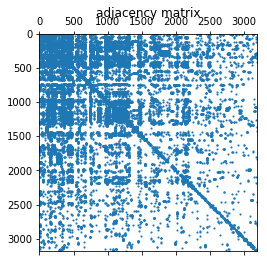

In [18]:
plt.spy(adjacency, markersize=1)
plt.title('adjacency matrix');

In [19]:
adjacency.shape

(3186, 3186)

In [249]:
weighted_matrix = np.zeros((n_nodes, n_nodes), dtype = int)

for idx, row in edges.iterrows():
    i, j = int(row.node_idx_source), int(row.node_idx_destination)
    
    source_coords = (nodes.loc[row.source_airport_id]["Latitude"], nodes.loc[row.source_airport_id]["Longitude"])    
    dest_coords = (nodes.loc[row.destination_airport_id]["Latitude"], nodes.loc[row.destination_airport_id]["Longitude"])
    
    weighted_matrix[i, j] = distance.geodesic(source_coords, dest_coords).km

In [234]:
#Weihted_matrix with inverse distances as weights

#try change diagonal coord to big value..

weighted_matrix_inv = np.zeros((n_nodes, n_nodes))

for idx, row in edges.iterrows():
    i, j = int(row.node_idx_source), int(row.node_idx_destination)
    
    if i != j:
        source_coords = (nodes.loc[row.source_airport_id]["Latitude"], nodes.loc[row.source_airport_id]["Longitude"])    
        dest_coords = (nodes.loc[row.destination_airport_id]["Latitude"], nodes.loc[row.destination_airport_id]["Longitude"])

        weighted_matrix_inv[i, j] = 1/(distance.geodesic(source_coords, dest_coords).km)
    else:
        weighted_matrix_inv[i, j] = 1

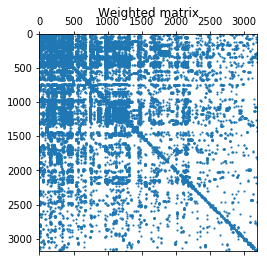

In [250]:
plt.spy(weighted_matrix, markersize=1)
plt.title('Weighted matrix');

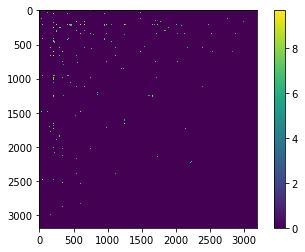

In [262]:
plt.imshow(np.log(weighted_matrix + 1))
plt.colorbar()

In [252]:
n_nodes = weighted_matrix.shape[0]
values = []

for i in range(n_nodes):
    for j in range(n_nodes):
        if weighted_matrix[i][j] != 0:
            values.append(weighted_matrix[i][j])

In [ ]:
plt.hist(values, bins = int(np.sqrt(n_nodes)));

/home/amaury/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


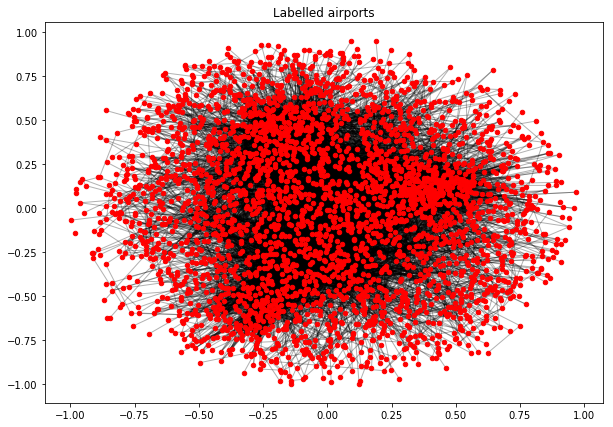

In [246]:
import networkx as nx

graph = nx.from_numpy_matrix(weighted_matrix_inv)
coords = nx.spring_layout(graph)

plt.figure(figsize=(10,7))
nc = nx.draw_networkx_nodes(graph, coords, node_size=20, cmap=plt.cm.jet)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Labelled airports");

In [25]:
#nx.write_gexf(graph,'graph_project.gexf')

In [26]:
dic = {"America":1, "Asia":2,"Europe":3,"Africa":4,"Pacific":5,"Australia":6,"Atlantic":7,"Indian":8,"Arctic":9,"\\N":10,np.nan:10}

labels = nodes.Continent
labels = np.array(labels.replace(dic).tolist())

In [27]:
S = nx.incidence_matrix(nx.from_numpy_matrix(weighted_matrix), oriented=True, weight='weight')

# gradient = scipy.sparse.csr_matrix(np.transpose(S))

edges_list = []
for i in range (n_nodes):
    for j in range (i,n_nodes):
        if weighted_matrix[i,j]>0:
            edges_list += [(i,j)]
        
s = np.zeros((n_nodes,len(edges_list)))

for edge_number,edge_coordinates in enumerate(edges_list):
    (i,j) = edge_coordinates
    if i == j: 
        continue
    wt = weighted_matrix[i][j]
    s[i,edge_number] = -np.sqrt(wt)
    s[j,edge_number] = np.sqrt(wt)

gradient = scipy.sparse.csr_matrix(np.transpose(s))

In [28]:
S.toarray()

array([[-1338., -1507., -1934., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [29]:
s

array([[-36.57868232, -38.82009789, -43.97726685, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [30]:
(S@S.T).toarray()

array([[7.6538184e+07, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0895152e+07, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 5.5677244e+07, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.5603600e+05,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.6810000e+03, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 2.4025000e+04]])

In [ ]:
sparse_weighted_matrix = sparse.csr_matrix(weighted_matrix)
laplacian = sparse.csgraph.laplacian(weighted_matrix)

computation =  scipy.linalg.eigh(laplacian)  #Compute orthonormale basis
eigenvectors = computation[1]
eigenvalues =  computation[0]

#Sort to have ordered eigenvalues
idx = eigenvalues.argsort()  
eigenvalues = np.round_(np.real(eigenvalues[idx]), 13) #to avoid the zero approximations
eigenvectors = np.real(eigenvectors[:,idx])

In [235]:
#inv weighted matrix

laplacian_inv = sparse.csgraph.laplacian(weighted_matrix_inv)

computation_inv =  scipy.linalg.eigh(laplacian_inv)  #Compute orthonormale basis
eigenvectors_inv = computation_inv[1]
eigenvalues_inv =  computation_inv[0]

#Sort to have ordered eigenvalues
idx_inv = eigenvalues_inv.argsort()  
eigenvalues_inv = np.real(eigenvalues_inv[idx_inv])
eigenvectors_inv = np.real(eigenvectors_inv[:,idx_inv])

In [32]:
labels_bin = np.ones(n_nodes)
for i in range(n_nodes):
    if (labels[i] != 1):  #choice : American aiports = 1, the others = -1
        labels_bin[i] = -1
    else:
        labels_bin[i] = 1

In [33]:
mn_ratio = 0.3
m = int(mn_ratio * n_nodes)  # Number of measurements.

# Mask
np.random.seed(555)
w = np.random.rand(n_nodes) < mn_ratio

In [236]:
Y = eigenvectors_inv[:, 1:3]

In [237]:
from sklearn.cluster import KMeans

In [238]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(Y)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

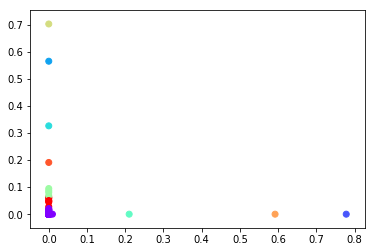

In [239]:
plt.scatter(Y[:,0],Y[:,1], c=kmeans.labels_, cmap='rainbow')  
plt.show()

In [240]:
lab = kmeans.labels_

In [241]:
dic_color = {0: "BLUE",
             1: "TEAL",
             2: "GREEN",
             3: "YELLOW",
             4: "RED",
             5: "FUCHSIA",
             6: "BLACK",
             7: "SILVER",
             8: "OLIVE",
             9: "ORANGE"
}

In [242]:
lab_color = [dic_color[lab[i]] for i in range(len(lab))]

/home/amaury/anaconda3/envs/ntds_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


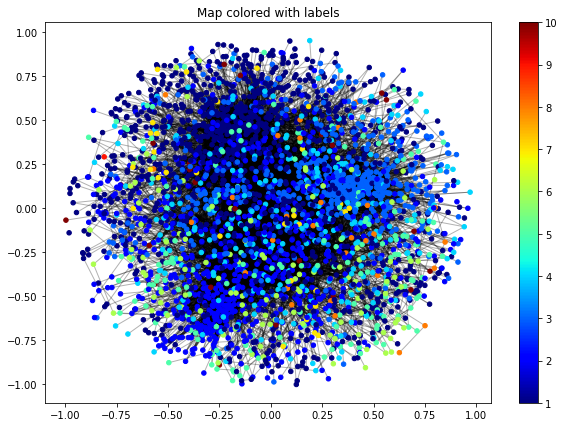

In [248]:
subsampled_signal = np.ones(n_nodes)*np.nan
subsampled_signal[w] = labels[w]
plt.figure(figsize=(10,7))

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=labels, cmap=plt.cm.jet)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.colorbar(nc)
plt.title("Map colored with labels");

In [81]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """

    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

In [37]:
def P(a):
    b = np.zeros(len(w))
    
    b[~w] = a[~w]
    b[w] = labels_bin[w]
            
    return b

In [38]:
x0 = np.zeros(n_nodes)
x1 = np.zeros(n_nodes)

In [39]:
sol_1norm_min = graph_pnorm_interpolation(gradient=gradient, P=P, x0=x0, p=1, rtol=0.0001, maxit=10000)

sol_2norm_min = graph_pnorm_interpolation(gradient=gradient, P=P, x0=x1, p=2, rtol=0.0001, maxit=10000)

threshold = 0

sol_1norm_bin = (sol_1norm_min-threshold >= 0)*2 - 1

sol_2norm_bin = (sol_2norm_min-threshold >= 0)*2 - 1

Solution found after 34 iterations:
    objective function f(sol) = 3.235954e+05
    stopping criterion: RTOL
Solution found after 954 iterations:
    objective function f(sol) = 1.338001e+07
    stopping criterion: RTOL


C:\Users\guilh\Miniconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


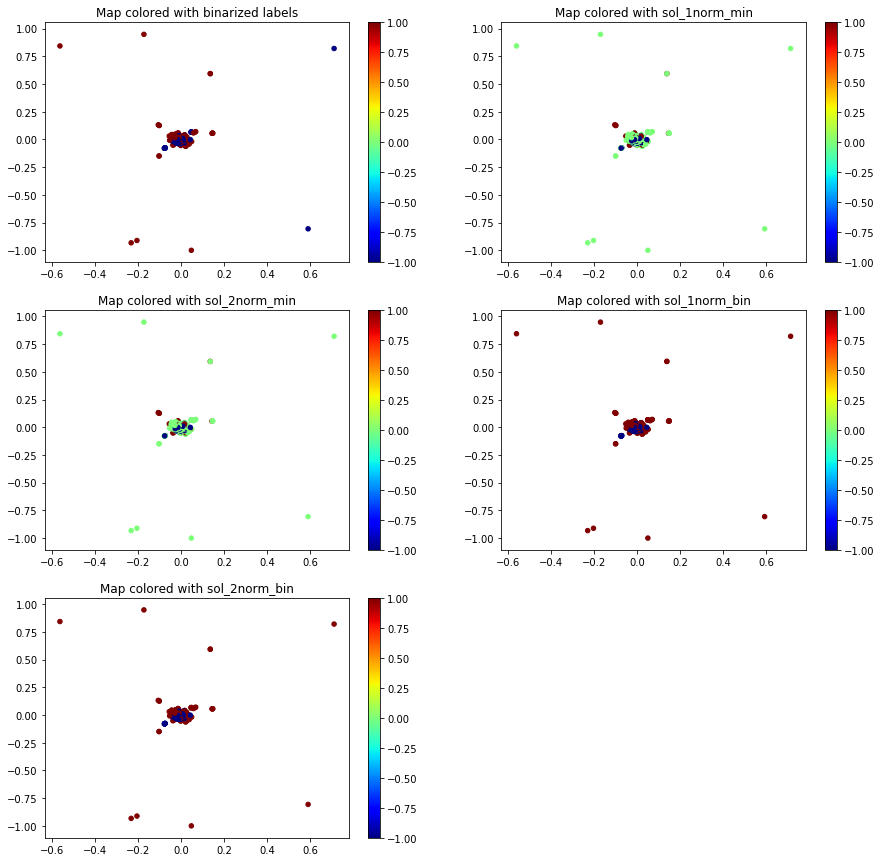

In [40]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=labels_bin, cmap=plt.cm.jet, ax=ax[0,0])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[0,0])
plt.colorbar(nc, ax=ax[0,0])
ax[0,0].set_title("Map colored with binarized labels")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=sol_1norm_min, cmap=plt.cm.jet, ax=ax[0,1])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[0,1])
plt.colorbar(nc, ax=ax[0,1])
ax[0,1].set_title("Map colored with sol_1norm_min")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=sol_2norm_min, cmap=plt.cm.jet, ax=ax[1,0])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[1,0])
plt.colorbar(nc, ax=ax[1,0])
ax[1,0].set_title("Map colored with sol_2norm_min")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=sol_1norm_bin, cmap=plt.cm.jet, ax=ax[1,1])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[1,1])
plt.colorbar(nc, ax=ax[1,1])
ax[1,1].set_title("Map colored with sol_1norm_bin")

nc = nx.draw_networkx_nodes(graph, coords, node_size=20, node_color=sol_2norm_bin, cmap=plt.cm.jet, ax=ax[2,0])
nx.draw_networkx_edges(graph, coords, alpha=0.3, ax=ax[2,0])
plt.colorbar(nc, ax=ax[2,0])
ax[2,0].set_title("Map colored with sol_2norm_bin")

ax[2,1].remove();

In [41]:
#Easier way to see the percentage of good nodes
correct1 = 0
correct2 = 0
for i in range(n_nodes):
    if labels_bin[i]==sol_1norm_bin[i]:
        correct1+=1
    if labels_bin[i]==sol_2norm_bin[i]:
        correct2+=1
print('Norm 1:',np.round(correct1/n_nodes*100,1),'% true.')
print('Norm 2:',np.round(correct2/n_nodes*100,1),'% true.')

Norm 1: 98.1 % true.
Norm 2: 98.0 % true.


In [42]:
(S@S.T.toarray()).shape

(3186, 3186)

In [43]:
gradient.T@gradient.toarray()

array([[27975.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,  7916.,     0., ...,     0.,     0.,     0.],
       [    0.,     0., 26362., ...,     0.,     0.,     0.],
       ...,
       [    0.,     0.,     0., ...,   506.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,    41.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,   155.]])

In [44]:
np.count_nonzero(laplacian)

39594

In [45]:
sum(sum(laplacian==np.round(gradient.T@gradient,0).toarray()))/(gradient.shape[1]*gradient.shape[1])

0.9998784307837687

In [46]:
c = np.round(gradient.T@gradient,0).toarray()
for i in range(gradient.shape[1]):
    print(i)
    for j in range(gradient.shape[1]):
        a = laplacian[i][j]
        b = c[i][j]
        if a!=b:
            print(i,j,a,b)

0
0 0 31898 27975.0
1
2
3
3 3 504059 501289.0
4
5
6
7
8
8 8 251474 235847.0
9
10
11
12
13
13 13 127030 122999.0
14
14 14 132253 128591.0
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
32 32 42745 47870.0
33
33 33 78261 85623.0
34
35
36
36 36 31028 26855.0
37
37 37 84017 89067.0
38
38 38 25758 27253.0
39
39 39 20302 16306.0
40
40 40 27242 31577.0
41
42
43
43 43 36245 46077.0
44
45
46
46 46 50787 37837.0
47
48
49
49 49 96808 98196.0
50
50 50 157169 159940.0
51
51 51 121298 115847.0
52
52 50 0 -2771.0
52 52 204172 197782.0
53
54
54 54 248770 251430.0
55
55 55 345321 354086.0
56
57
57 57 223211 225183.0
58
59
59 59 1008 1127.0
60
61
62
63
64
65
66
67
68
68 68 165497 165238.0
69
70
71
72
73
74
74 59 0 -119.0
75
75 75 542 633.0
76
76 75 0 -91.0
76 76 91 119.0
77
78
79
80
81
82
83
83 8 -4329 0.0
83 13 -4031 0.0
83 83 109036 111492.0
84
85
86
87
88
89
90
91
92
93
94
95
96
97
97 97 78796 78538.0
98
99
100
101
102
102 38 0 -5807.0
103
103 38 -6133 0.0
103 103 366686 368844.0
104
105
106
1

631
631 628 0 -279.0
631 631 3523 4446.0
632
633
634
634 634 3215 3435.0
635
635 631 0 -413.0
636
637
638
638 426 -1502 0.0
639
639 639 43457 43245.0
640
640 216 -2926 0.0
640 404 0 -5176.0
640 640 235812 241242.0
641
642
643
644
645
646
647
647 155 0 -4767.0
648
648 415 0 -1492.0
648 470 -1414 0.0
648 648 57700 58656.0
649
650
651
651 651 1092 893.0
652
653
654
655
655 651 -199 0.0
656
657
657 657 1323 1418.0
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
673 171 0 -2122.0
674
675
675 675 255 246.0
676
677
678
678 678 1221 1095.0
679
680
681
682
683
683 488 -809 0.0
684
685
686
687
688
689
690
690 690 802 762.0
691
692
693
694
695
695 494 0 -246.0
695 695 275 322.0
696
696 696 300 438.0
697
698
698 696 -190 0.0
699
699 699 336 454.0
700
701
702
703
704
704 704 197 127.0
705
705 488 -467 0.0
705 690 -40 0.0
705 696 0 -111.0
705 705 134 111.0
706
707
707 494 -247 0.0
707 505 0 -67.0
708
709
709 705 -23 0.0
710
710 675 -47 0.0
710 710 11 249.0
711
711 711 3322 3487.0
712

1258 1079 0 -2382.0
1259
1260
1261
1262
1263
1264
1264 1264 30796 32694.0
1265
1266
1267
1268
1269
1270
1270 1253 -1161 0.0
1271
1272
1273
1274
1274 455 0 -6732.0
1274 1085 -174 0.0
1275
1276
1276 355 -5152 0.0
1277
1277 739 0 -2973.0
1277 1225 0 -2861.0
1277 1277 56902 48252.0
1278
1279
1280
1280 183 0 -3099.0
1280 214 0 -2869.0
1280 478 0 -3346.0
1281
1282
1282 454 0 -1466.0
1283
1284
1285
1285 54 -269 0.0
1285 183 -3157 0.0
1285 214 -2929 0.0
1285 478 -3403 0.0
1285 1050 0 -2839.0
1285 1209 0 -3111.0
1286
1286 437 0 -807.0
1287
1288
1289
1289 437 -782 0.0
1290
1290 354 0 -5587.0
1291
1291 211 -1807 0.0
1292
1292 183 -100 0.0
1293
1293 49 0 -1388.0
1293 442 0 -268.0
1293 472 0 -1371.0
1293 1293 30007 30264.0
1294
1294 342 0 -4062.0
1295
1296
1296 57 -3917 0.0
1297
1298
1299
1300
1301
1302
1302 211 -2009 0.0
1302 444 0 -392.0
1303
1303 211 0 -7762.0
1303 371 -603 0.0
1303 1277 -2920 0.0
1303 1303 42761 42600.0
1304
1304 110 -499 0.0
1304 1304 126 0.0
1305
1305 110 0 -552.0
1305 1304 -

1865
1866
1867
1867 1862 -65 0.0
1868
1868 1855 -335 0.0
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1898 1306 -2676 0.0
1898 1898 19845 19437.0
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1955 37 -270 0.0
1955 1955 52 0.0
1956
1956 1955 -52 0.0
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1970 8 -3287 0.0
1970 1970 13012 12526.0
1971
1971 3 -2770 0.0
1971 14 -1715 0.0
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1986 1986 2183 2136.0
1987
1988
1989
1989 1989 3967 4190.0
1990
1991
1991 1991 2167 2359.0
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2005 1970 -486 0.0
2

2739 2729 -182 0.0
2739 2736 0 -109.0
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2754 124 0 -714.0
2754 1479 -359 0.0
2755
2755 124 0 -871.0
2755 1481 -801 0.0
2756
2756 1479 0 -552.0
2756 1481 -459 0.0
2757
2758
2759
2759 1093 0 -891.0
2759 2759 891 996.0
2760
2761
2761 1093 0 -836.0
2761 2761 836 996.0
2762
2762 2762 13793 14443.0
2763
2764
2765
2766
2767
2768
2769
2770
2771
2771 2762 0 -650.0
2771 2771 12629 12825.0
2772
2773
2773 2759 0 -105.0
2773 2761 0 -160.0
2774
2775
2776
2777
2778
2778 2771 0 -196.0
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2801 453 0 -1677.0
2802
2802 453 0 -1423.0
2803
2804
2804 2804 82 155.0
2805
2805 2805 170 224.0
2806
2806 97 -258 0.0
2806 2805 0 -224.0
2807
2807 1373 -136 0.0
2807 1397 0 -261.0
2807 2807 361 261.0
2808
2808 1397 0 -309.0
2808 2804 -82 0.0
2809
2809 2809 0 130.0
2810
2810 2805 -170 0.0
2810 2809 0 -130.0
2811
2811 2807 -100 0.0
2812


In [61]:
import folium

In [62]:
coord = np.zeros((max(nodes.index)+1,2))
for i in nodes.iterrows():
    coord[i[0]] = (i[1].Latitude, i[1].Longitude)

In [243]:
mapit = folium.Map(tiles="Mapbox Bright")
j=0

for i in nodes.iterrows():
    coord_ = [i[1].Latitude, i[1].Longitude]
    folium.CircleMarker( location=coord_, radius=1, color=lab_color[j], fill=True).add_to( mapit )
    j += 1
    
# for i in edges.iloc[:].iterrows():
#     my_edge = [coord[i[1].source_airport_id], coord[i[1].destination_airport_id]]
#     folium.vector_layers.PolyLine(my_edge, color="black", weight=0.5, opacity=0.5).add_to( mapit )
               

In [244]:
mapit.save('mapit.html')

In [245]:
np.unique(lab_color, return_counts=True)

(array(['BLACK', 'BLUE', 'FUCHSIA', 'GREEN', 'OLIVE', 'ORANGE', 'RED',
        'SILVER', 'TEAL', 'YELLOW'], dtype='<U7'),
 array([   1, 3169,    4,    1,    1,    6,    1,    1,    1,    1]))